In [1]:
#Install necessary libraries
!pip install scikit-learn
!pip install pandas
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import re
from cycler import cycler

# Load the MovieLens 1M dataset
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')

users = pd.read_csv('./ml-1m/users.dat', sep='::', names=['UserID', 'Gender','Age','Occupation','Zip-code'], engine='python')

movies = pd.read_csv('./ml-1m/movies.dat', sep='::', names=['MovieID','Title','Genres'], engine='python',encoding='latin-1')
movies['Genres Reduced'] = movies['Genres'].map(lambda m: m.split('|')[0])
movies['Year'] = movies['Title'].map(lambda m: int(re.search('\w*\((\d*)\)', m).group(1)))


/home/bvankooten/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load in User and Movie representations generated by Matrix Facotization algorithm
U = np.loadtxt('feature_matrices/users.csv', delimiter=',')
M = np.loadtxt('feature_matrices/movies.csv', delimiter=',')

For this part of the assignment, we visualize the matrices of features which characterize users and movies. These features have a very high dimensionality. Therefore, in order to visualize these matrices, we have to apply a dimensionality reduction algorithm. For this, we work with the following algorithms: **PCA, UMAP, t-SNE**.

With the data that is available about the movies and users, we try to see if there is clustering for certain characteristics of the data. For movies, we look at both the genre of the movie and the year it was released. For users, we look at the age group of the user and their gender.

## Movie Genre
First, we look at the clustering of movie genres. From the MovieLens data, we find that every movie can have multiple genres. Since this means that there will be too many categories, we first reduce the number of categories by only selecting the first named genre. Below, we find the resulting visualizations for all three algorithms.

In [4]:
def visualize_genre(method, ax):
    if method == "PCA":
        model = PCA(n_components=2)
    elif method == "t-SNE":
        model = TSNE(n_components=2, learning_rate='auto', init='random')
    elif method == "UMAP":
        model = umap.UMAP(n_components=2, init='random', random_state=0)
    else:
        model = None
    
    representations = model.fit_transform(M)
    genre_representations = []
    for g in movies['Genres Reduced'].unique():
        is_genre = []
        for i in range(1, len(representations) + 1):
            m = movies[movies['MovieID'] == i]['Genres Reduced']
            is_genre.append(len(m) != 0 and m.item() == g)
        genre_representations.append(representations[is_genre])

    ax.set_prop_cycle(cycler('color', plt.cm.tab20.colors))

    for i, genre in enumerate(movies['Genres Reduced'].unique()):
        ax.plot(genre_representations[i][:,0], genre_representations[i][:,1], '.', label=genre)
    ax.set_title(method)
    ax.set_xlabel('Dimension 1')

/home/bvankooten/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


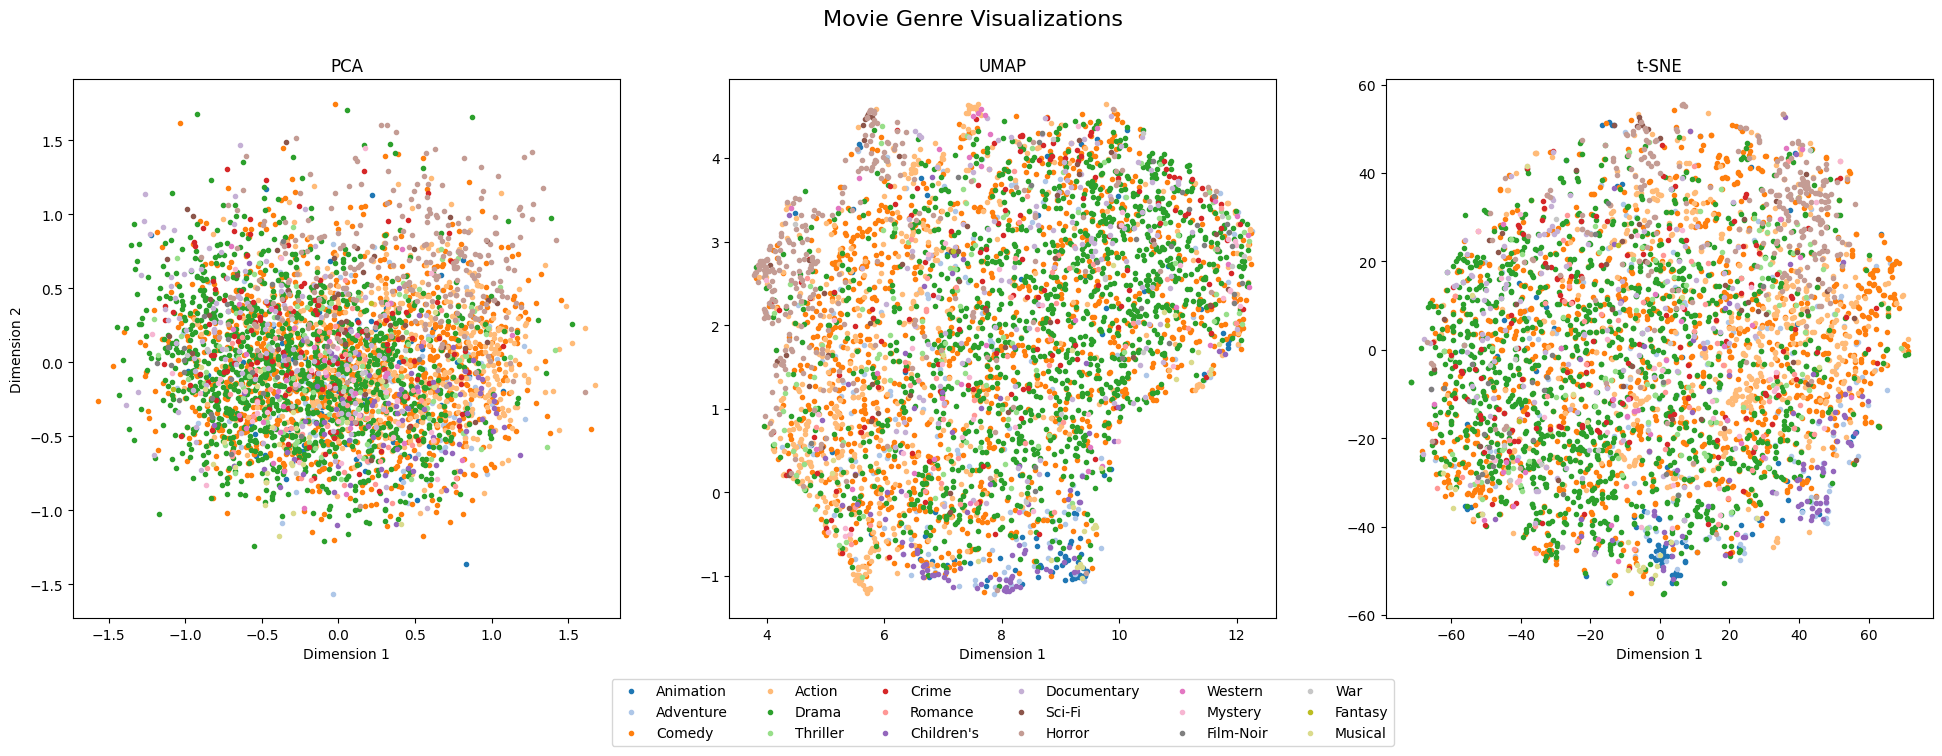

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
for method, ax in zip(['PCA', 'UMAP', 't-SNE'], axs):
    visualize_genre(method, ax)

fig.suptitle('Movie Genre Visualizations', fontsize=16)
axs[0].set_ylabel('Dimension 2')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=6, fancybox=True)

In the resulting visualizations, we can see a couple of things. Overall, we find that for the PCA algorithm it is hardest to see any clustering. This is mainly caused by the fact that everything is stacked closer together. There are still a couple of findings that can be concluded from this visualization. The biggest groups of genre are Drama, Comedy, and Action. In the visualizations, we can find that Drama tends to cluster around a different side of the visualization than Comedy and Action. This makes logical sense, since in terms of movies these are generally further apart in terms of types of people who like watching them.

In both UMAP and t-SNE, we can see a couple of genre's that show some clustering. These genre's are Children's, Animation, Horror. We can also see that the Children's and Animation genre are clustering relatively close to each other in both cases. This is also logical, since it is likely that a lot of movies that are labeled with the Children genre, are also labeled with the Animation genre and vice versa. 

Overall, some clustering can be found in the visualizations, but overall it is not extremely convincing. A large contribution to the worse clustering is likely the fact that we reduce the movies to a single genre.

## Movie Release Year
Again, with the movie release year, we find that there are too many individual years to plot them all. Because of this, we decided to group the movies. Initially, we picked groups of 10 years (with an extra year added at both ends of the year range). However, it seemed like there were a way larger amount of movies in the final group. Because of this, we split up this group into two. Below we find the visualizations for all three algorithms.

In [6]:
def visualize_year(method, ax):
    if method == "PCA":
        model = PCA(n_components=2)
    elif method == "t-SNE":
        model = TSNE(n_components=2, learning_rate='auto', init='random')
    elif method == "UMAP":
        model = umap.UMAP(n_components=2, init='random', random_state=0)
    else:
        model = None
    
    representations = model.fit_transform(M)

    year_ranges = [(1919,1929),(1930,1939),(1940,1949),(1950,1959),(1960,1969),(1970,1979),(1980,1989),(1990,1995),(1996,2000)]

    year_representations = []
    for y0, y1 in year_ranges:
        is_year = []
        for i in range(1, len(representations) + 1):
            m = movies[movies['MovieID'] == i]['Year']
            is_year.append(len(m) != 0 and m.item() >= y0 and m.item() <= y1)
        year_representations.append(representations[is_year])

    for i, (y0, y1) in enumerate(year_ranges):
        ax.plot(year_representations[i][:,0], year_representations[i][:,1], '.', label="{}-{}".format(y0,y1), alpha=0.75)
    ax.set_title(method)
    ax.set_xlabel('Dimension 1')

/home/bvankooten/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


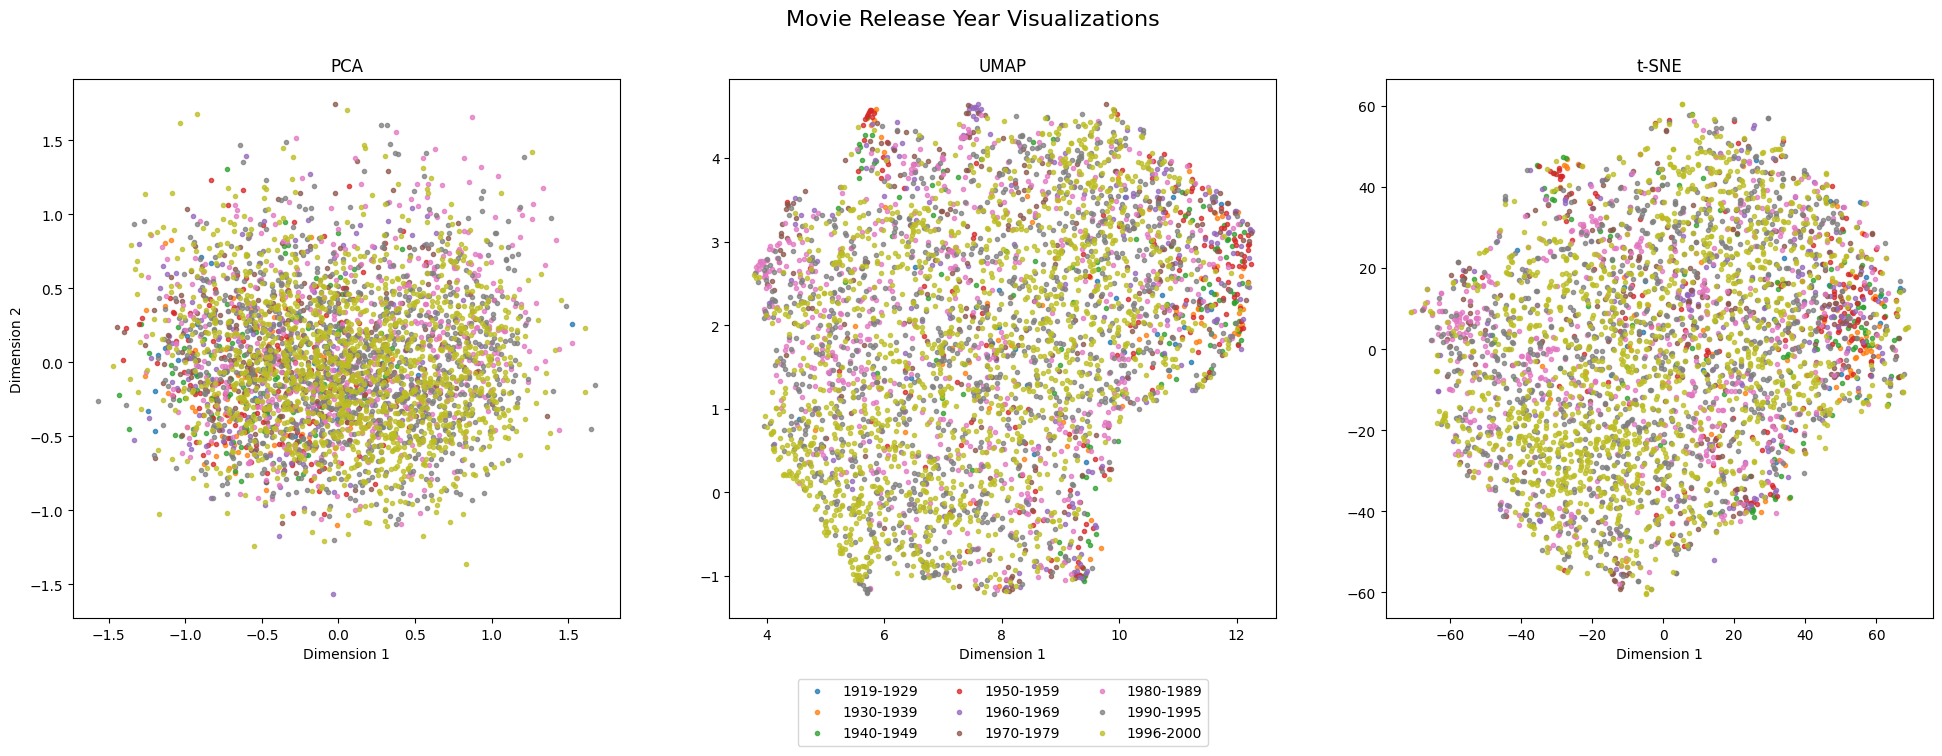

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
for method, ax in zip(['PCA', 'UMAP', 't-SNE'], axs):
    visualize_year(method, ax)

fig.suptitle('Movie Release Year Visualizations', fontsize=16)
axs[0].set_ylabel('Dimension 2')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=3, fancybox=True)

Again, we see that the visualization for PCA is the hardest to find the clustering on. Overall, we find that the movies that were released in the later years do not really show any clear clustering. A potential reason as to why this is the case might be the greater number of movies released in these years.

For all three algorithms, we do see that there is some clustering for the movies released in the earlier years, though sometimes in multiple groups. 

## User Age
For the User Age data, no special changes to the data had to be performed. The user age was already divided up into seven age groups. The visualizations for all three algorithms can be found below.

In [8]:
def visualize_age(method, ax):
    if method == "PCA":
        model = PCA(n_components=2)
    elif method == "t-SNE":
        model = TSNE(n_components=2, learning_rate='auto', init='random')
    elif method == "UMAP":
        model = umap.UMAP(n_components=2, init='random', random_state=0)
    else:
        model = None
    
    representations = model.fit_transform(U)

    age_ranges = [(1,"Under 18"),(18,"18-24"),(25,"25-34"),(35,"35-44"),(45,"45-49"),(50,"50-55"),(56,"56+")]

    age_representations = []
    for (a,_) in age_ranges:
        is_age = []
        for i in range(1, len(representations) + 1):
            u = users[users['UserID'] == i]['Age']
            is_age.append(len(u) != 0 and u.item() == a)
        age_representations.append(representations[is_age])

    for i, (a,label) in enumerate(age_ranges):
        ax.plot(age_representations[i][:,0], age_representations[i][:,1], '.', label=label)
    ax.set_title(method)
    ax.set_xlabel('Dimension 1')

/home/bvankooten/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


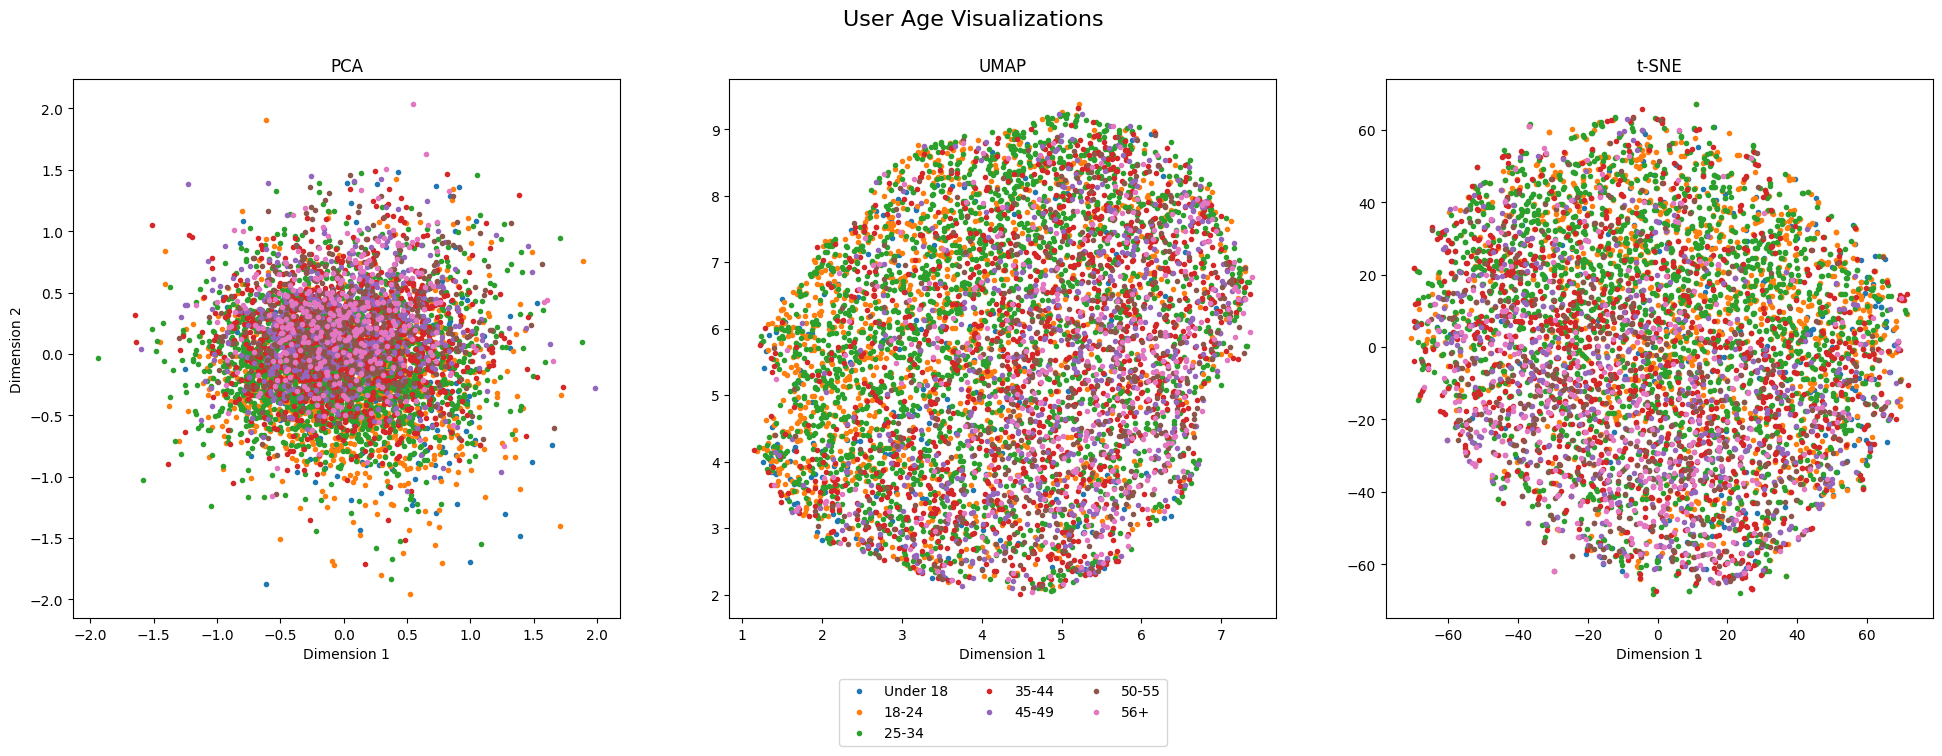

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
for method, ax in zip(['PCA', 'UMAP', 't-SNE'], axs):
    visualize_age(method, ax)

fig.suptitle('User Age Visualizations', fontsize=16)
axs[0].set_ylabel('Dimension 2')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=3, fancybox=True)

For this visualization, we can clearly see some nice clustering for all age ranges. The different age ranges do have some overlap, but only with the age ranges that are near it. Because of this, we can see a nice gradient across the age spectrum in all three visualizations.

## User Gender
Again, we did not have to alter the gender data, since it is already divided into two groups. The visualizations for all three algorithms can be found below.

In [10]:
def visualize_gender(method, ax):
    if method == "PCA":
        model = PCA(n_components=2)
    elif method == "t-SNE":
        model = TSNE(n_components=2, learning_rate='auto', init='random')
    elif method == "UMAP":
        model = umap.UMAP(n_components=2, init='random', random_state=0)
    else:
        model = None
    
    representations = model.fit_transform(U)

    gender_representations = []
    for g in list(reversed(users['Gender'].unique())):
        is_gender = []
        for i in range(1, len(representations) + 1):
            u = users[users['UserID'] == i]['Gender']
            is_gender.append(len(u) != 0 and u.item() == g)
        gender_representations.append(representations[is_gender])

    for i, g in enumerate(list(reversed(users['Gender'].unique()))):
        ax.plot(gender_representations[i][:,0], gender_representations[i][:,1], '.', label=g)
    ax.set_title(method)
    ax.set_xlabel('Dimension 1')

/home/bvankooten/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


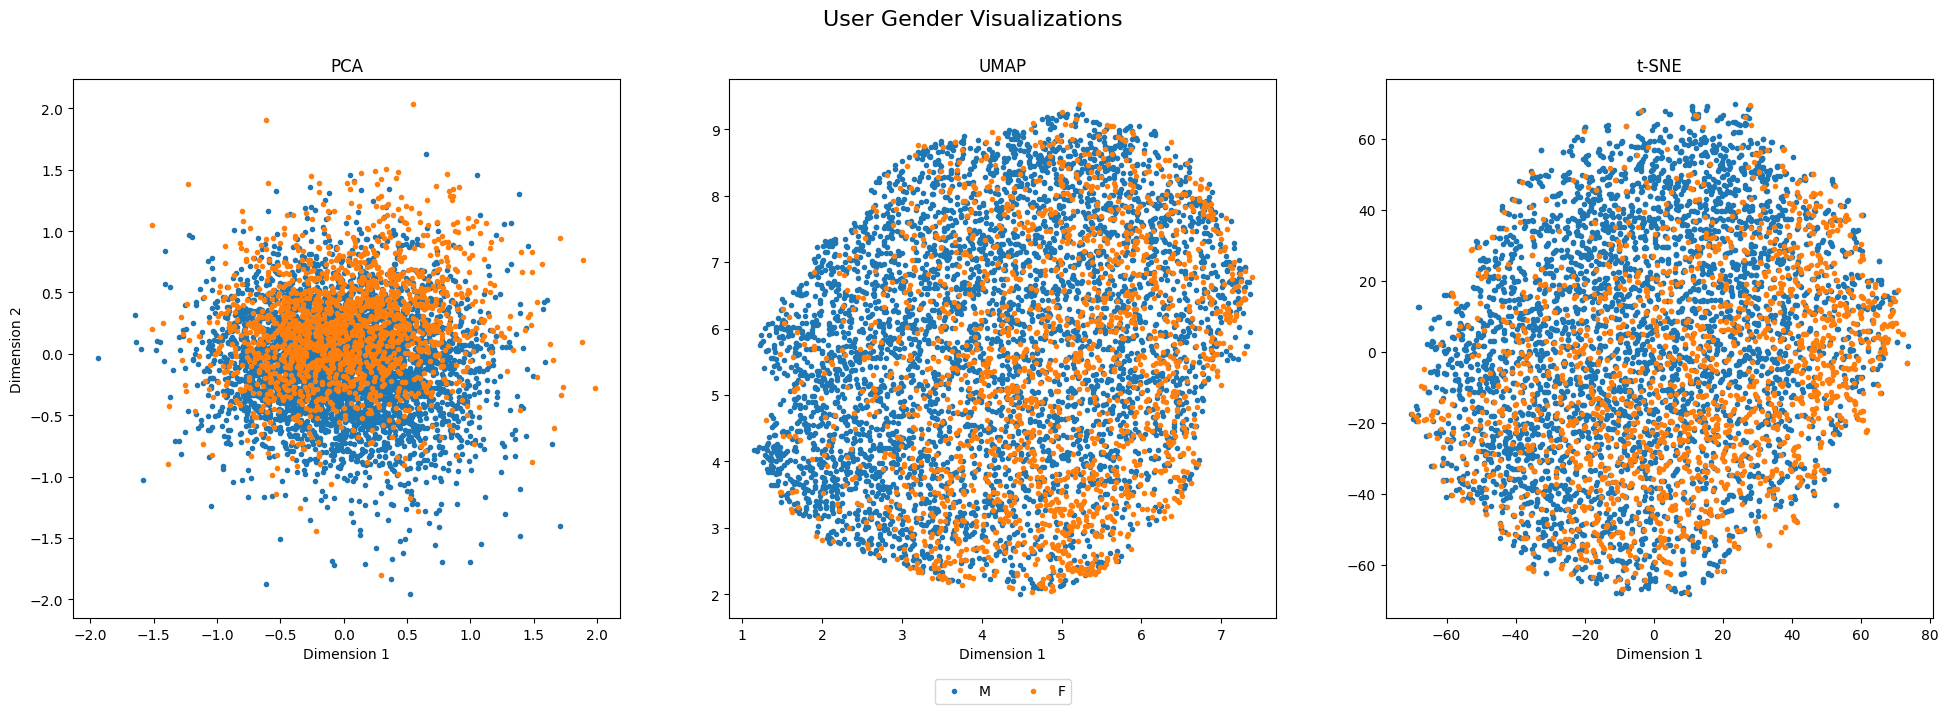

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
for method, ax in zip(['PCA', 'UMAP', 't-SNE'], axs):
    visualize_gender(method, ax)

fig.suptitle('User Gender Visualizations', fontsize=16)
axs[0].set_ylabel('Dimension 2')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=3, fancybox=True)

These visualizations show the clearest clustering of all comparisons, having a clear divide between Male and Female users. There is some overlap in the middle, but this is to be expected. 